In [1]:
!pip install keras pandas matplotlib torch opencv-python seaborn ultralytics scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [2]:
# -------------------- Imports --------------------

import os
import csv
import keras
import pandas as pd
import matplotlib.pyplot as plt
import random
import shutil
import torch
import cv2
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [12]:
# -------------------- Config --------------------

DATASET_ROOT_DIR = "./dataset/leaf_dataset"
YOLO_MATCHED_DS_DIR = f'{DATASET_ROOT_DIR}/yolo_matched'
DATA_YAML_NAME = "data.yaml"
YOLO_RUNS_DIR = './yolo-runs/yolo11x-leaf-detector'

TRAIN_SPLIT_RATIO = 0.8
VALIDATION_SPLIT_RATIO = 0.1
TEST_SPLIT_RATIO = 0.1

SEED = 42
BASE_MODEL = 'yolo11x.pt'
EPOCHS = 60
PATIENCE = 5
BATCH_SIZE = 8
LEARNING_RATE = 0.001
INPUT_IMAGE_SIZE = 640

random.seed(SEED)

In [4]:
# -------------------- Helper functions --------------------

def csv_to_dataframe(csv_filepath, columns_name):
    df = pd.read_csv(csv_filepath, names=columns_name, header=0)
    return df


def calc_percentage(df_total, df_part, file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100


def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)


def create_yaml_data(yaml_file_name, output_dir, data):
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, yaml_file_name)
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')


def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height


def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data = {}
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
        if image_id not in data:
            data[image_id] = []
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')


def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')


def leaf_detect(img_path, model):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    return detect_img


def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
    plt.show()


def show_csv_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0, 0])
    sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0, 1])
    sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1, 0])
    sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1, 1])
    sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2, 0])
    sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2, 1])
    sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3, 0])
    sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3, 1])
    sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4, 0])
    sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4, 1])
    axs[0, 0].set(title='Train Box Loss')
    axs[0, 1].set(title='Train Class Loss')
    axs[1, 0].set(title='Train DFL Loss')
    axs[1, 1].set(title='Metrics Precision (B)')
    axs[2, 0].set(title='Metrics Recall (B)')
    axs[2, 1].set(title='Metrics mAP50 (B)')
    axs[3, 0].set(title='Metrics mAP50-95 (B)')
    axs[3, 1].set(title='Validation Box Loss')
    axs[4, 0].set(title='Validation Class Loss')
    axs[4, 1].set(title='Validation DFL Loss')
    plt.suptitle('Training Metrics and Loss', fontsize=24)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()


def show_directory_images(directory, num_images, rows=3, columns=3):
    archivos_imagen = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(archivos_imagen))):
        img_path = os.path.join(directory, archivos_imagen[i])
        img = cv2.imread(img_path)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(img)
        ax.axis('off')
    for j in range(num_images, rows * columns):
        ax = fig.add_subplot(rows, columns, j + 1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def show_metrics(metrics):
    ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])
    ax.set_title('YOLO Evaluation Metrics')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center',
                    va='bottom')
    plt.show()


def show_detections(images_dir, num_images=16, rows=4, columns=4):
    image_files = os.listdir(images_dir)
    selected_images = random.sample(image_files, num_images)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))
    for i, img_file in enumerate(selected_images):
        row_idx = i // columns
        col_idx = i % columns
        img_path = os.path.join(images_dir, img_file)
        detect_img = leaf_detect(img_path, model)
        axes[row_idx, col_idx].imshow(detect_img)
        axes[row_idx, col_idx].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


def show_image(img_path):
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [5]:
# -------------------- Split dataset --------------------

columns_name = ['image_id', 'width', 'height', 'bbox']
csv_filepath = f'{DATASET_ROOT_DIR}/train.csv'

annotations = csv_to_dataframe(csv_filepath, columns_name)
df = pd.DataFrame(annotations)

unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, train_size=TRAIN_SPLIT_RATIO,
                                                       random_state=SEED)
train_df = df[df['image_id'].isin(train_filenames)]

temp_ratio = TEST_SPLIT_RATIO / (VALIDATION_SPLIT_RATIO + TEST_SPLIT_RATIO)
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=temp_ratio, random_state=SEED)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]

In [6]:
# -------------------- Evaluate Datasets --------------------

train_percentage = calc_percentage(df, train_df, 'image_id')
print(f'Elements in train_df({train_percentage}%):', len(train_df['image_id'].unique()))

val_percentage = calc_percentage(df, val_df, 'image_id')
print(f'Elements in val_df({val_percentage}%):', len(val_df['image_id'].unique()))

test_percentage = calc_percentage(df, test_df, 'image_id')
print(f'Elements in test_df({test_percentage}%):', len(test_df['image_id'].unique()))

Elements in train_df(80.0%): 904
Elements in val_df(10.0%): 113
Elements in test_df(10.0%): 113


In [7]:
# -------------------- Create YAML data file for YOLO --------------------

yaml_data = {
    'train': os.path.abspath(f'{YOLO_MATCHED_DS_DIR}/train/images'),
    'val': os.path.abspath(f'{YOLO_MATCHED_DS_DIR}/valid/images'),
    'test': os.path.abspath(f'{YOLO_MATCHED_DS_DIR}/test/images'),
    'format': 'line_break',
    'nc': 1,
    'names': ['leaf']
}

create_yaml_data(DATA_YAML_NAME, YOLO_MATCHED_DS_DIR, yaml_data)

YAML file created successfully in /content/dataset/leaf_dataset/yolo_matched/data.yaml.


In [8]:
# -------------------- Move images into intended folders --------------------

all_images_path = f'{DATASET_ROOT_DIR}/train/'

# Data for train
train_labels = f'{YOLO_MATCHED_DS_DIR}/train/labels'
train_images = f'{YOLO_MATCHED_DS_DIR}/train/images'
move_images_to_directory(train_df, all_images_path, train_images)
dataframe_yolofiles(train_df, train_labels)

# Data for validation
valid_labels = f'{YOLO_MATCHED_DS_DIR}/valid/labels'
valid_images = f'{YOLO_MATCHED_DS_DIR}/valid/images'
move_images_to_directory(val_df, all_images_path, valid_images)
dataframe_yolofiles(val_df, valid_labels)

# Data for test
test_labels = f'{YOLO_MATCHED_DS_DIR}/test/labels'
test_images = f'{YOLO_MATCHED_DS_DIR}/test/images'
move_images_to_directory(test_df, all_images_path, test_images)
dataframe_yolofiles(test_df, test_labels)

Total images moved to: /content/dataset/leaf_dataset/yolo_matched/train/images
Total text files created in: /content/dataset/leaf_dataset/yolo_matched/train/labels
Total images moved to: /content/dataset/leaf_dataset/yolo_matched/valid/images
Total text files created in: /content/dataset/leaf_dataset/yolo_matched/valid/labels
Total images moved to: /content/dataset/leaf_dataset/yolo_matched/test/images
Total text files created in: /content/dataset/leaf_dataset/yolo_matched/test/labels


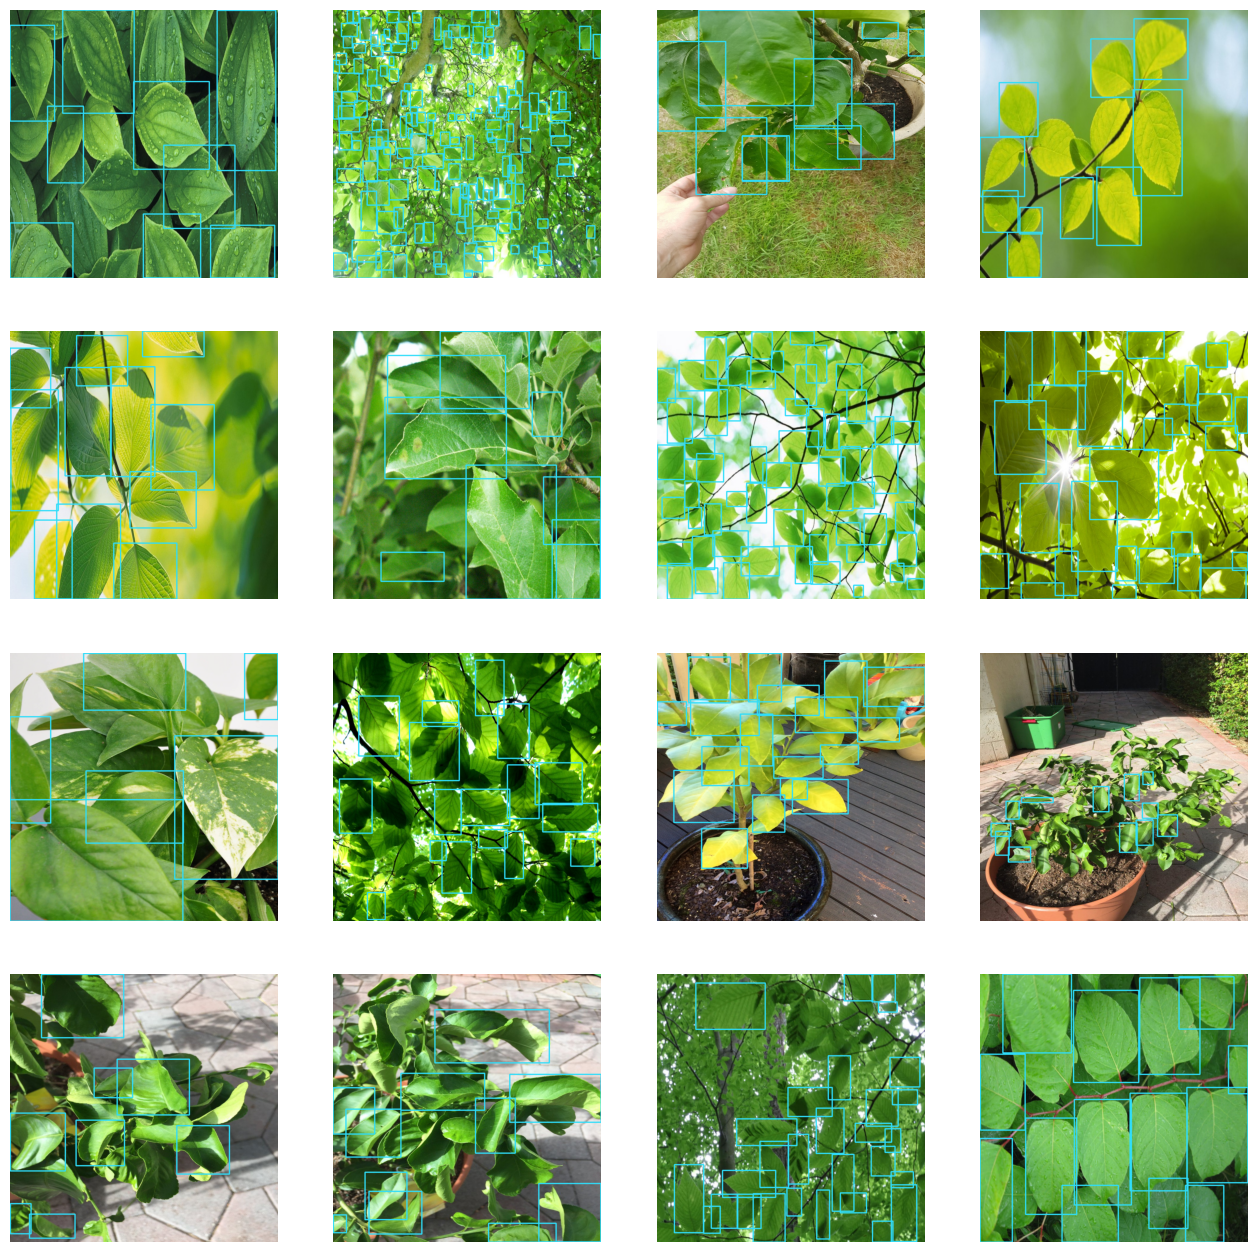

In [9]:
# -------------------- Plot train dataset --------------------

plot_images_with_detections(train_images, train_labels)

In [13]:
# -------------------- Select base YOLO model --------------------

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLO(BASE_MODEL)

print(f"Using device: {device}")

Using device: cuda


In [15]:
# -------------------- Train model --------------------

model.train(data = f'{YOLO_MATCHED_DS_DIR}/{DATA_YAML_NAME}',
            epochs = EPOCHS,
            imgsz = INPUT_IMAGE_SIZE,
            seed = SEED,
            batch = BATCH_SIZE,
            device = device,
            patience = PATIENCE,
            project = YOLO_RUNS_DIR,
            workers = 4)

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/leaf_dataset/yolo_matched/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, po

train: Scanning /content/dataset/leaf_dataset/yolo_matched/train/labels.cache... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 335.9±85.7 MB/s, size: 28.1 KB)


val: Scanning /content/dataset/leaf_dataset/yolo_matched/valid/labels.cache... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      9.87G      1.655      1.961       1.85         58        640: 100%|██████████| 113/113 [01:13<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

                   all        113        532     0.0317    0.00376     0.0208     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      9.81G      1.655      1.941      1.853         45        640: 100%|██████████| 113/113 [01:12<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all        113        532      0.417     0.0132     0.0236     0.0142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60       9.7G      1.626        1.9      1.845         49        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532      0.384      0.346      0.279      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      9.62G      1.628      1.938      1.858         51        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]

                   all        113        532      0.396      0.346      0.288      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      9.86G      1.616      1.885      1.866         93        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

                   all        113        532      0.434      0.413      0.372      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      9.62G      1.601      1.814      1.819         87        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all        113        532       0.45      0.385      0.368      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60       9.6G      1.551      1.766      1.782         61        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532      0.499      0.432      0.414      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      9.68G      1.548       1.76      1.761         42        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        113        532       0.42      0.409      0.339      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      9.82G      1.515      1.735      1.764         53        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532       0.45      0.455      0.416      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      9.61G      1.498       1.68      1.743         61        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

                   all        113        532      0.517      0.488      0.493      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      9.88G      1.463      1.615      1.704         68        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

                   all        113        532      0.511      0.444      0.445      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      9.63G      1.459      1.658      1.724         49        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.574      0.417      0.464      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      9.81G      1.447       1.62      1.692         43        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

                   all        113        532      0.551      0.498       0.52      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      9.62G      1.427      1.584      1.684         76        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532      0.481      0.498      0.479      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      9.81G      1.406      1.549      1.686         31        640: 100%|██████████| 113/113 [01:10<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all        113        532      0.589      0.492      0.513      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      9.74G      1.389      1.567      1.664         48        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

                   all        113        532      0.549      0.504      0.512      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      9.61G      1.391      1.523      1.674         57        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

                   all        113        532      0.505      0.487      0.469       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      9.81G      1.428      1.557       1.68         85        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

                   all        113        532      0.484      0.488      0.461       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      9.61G      1.383      1.493      1.676         38        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]

                   all        113        532      0.609      0.547      0.542      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      9.81G      1.363      1.475      1.648         41        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

                   all        113        532      0.578      0.444      0.476       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      9.62G      1.338      1.426      1.617         38        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


                   all        113        532      0.543      0.545       0.55      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      10.1G      1.389       1.45      1.644         43        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

                   all        113        532      0.512      0.528      0.522      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      9.62G      1.361       1.42      1.623         47        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

                   all        113        532      0.539      0.562      0.559      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      9.67G      1.328       1.38      1.618         39        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

                   all        113        532      0.548      0.522      0.521      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      9.85G      1.325      1.397      1.615        128        640: 100%|██████████| 113/113 [01:10<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

                   all        113        532      0.545      0.547       0.53       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      9.62G      1.317      1.441      1.603         80        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.574      0.502       0.54      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      9.62G      1.299      1.368      1.586         37        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.534      0.556       0.54      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      9.62G      1.274      1.307      1.564         56        640: 100%|██████████| 113/113 [01:10<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.614      0.544      0.584      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      9.62G      1.259       1.29      1.549         76        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532        0.6      0.492      0.555      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      9.61G       1.29      1.331      1.576         83        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532      0.564       0.56      0.557      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      9.61G      1.274       1.31      1.554         46        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.605      0.564      0.589      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      9.74G      1.241      1.261      1.548         53        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.596      0.533      0.579      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      9.62G      1.265      1.262      1.558        115        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.581      0.523      0.563      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      9.89G      1.273      1.285      1.574         87        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        113        532      0.592      0.499      0.569      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      9.61G      1.225      1.224      1.536         83        640: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all        113        532      0.566      0.556      0.563       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       9.7G      1.214      1.194      1.521        116        640: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]

                   all        113        532      0.588      0.562      0.585      0.375
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



36 epochs completed in 0.857 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 114.4MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


                   all        113        532      0.605      0.563      0.589      0.379
Speed: 0.6ms preprocess, 25.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe7601e14d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

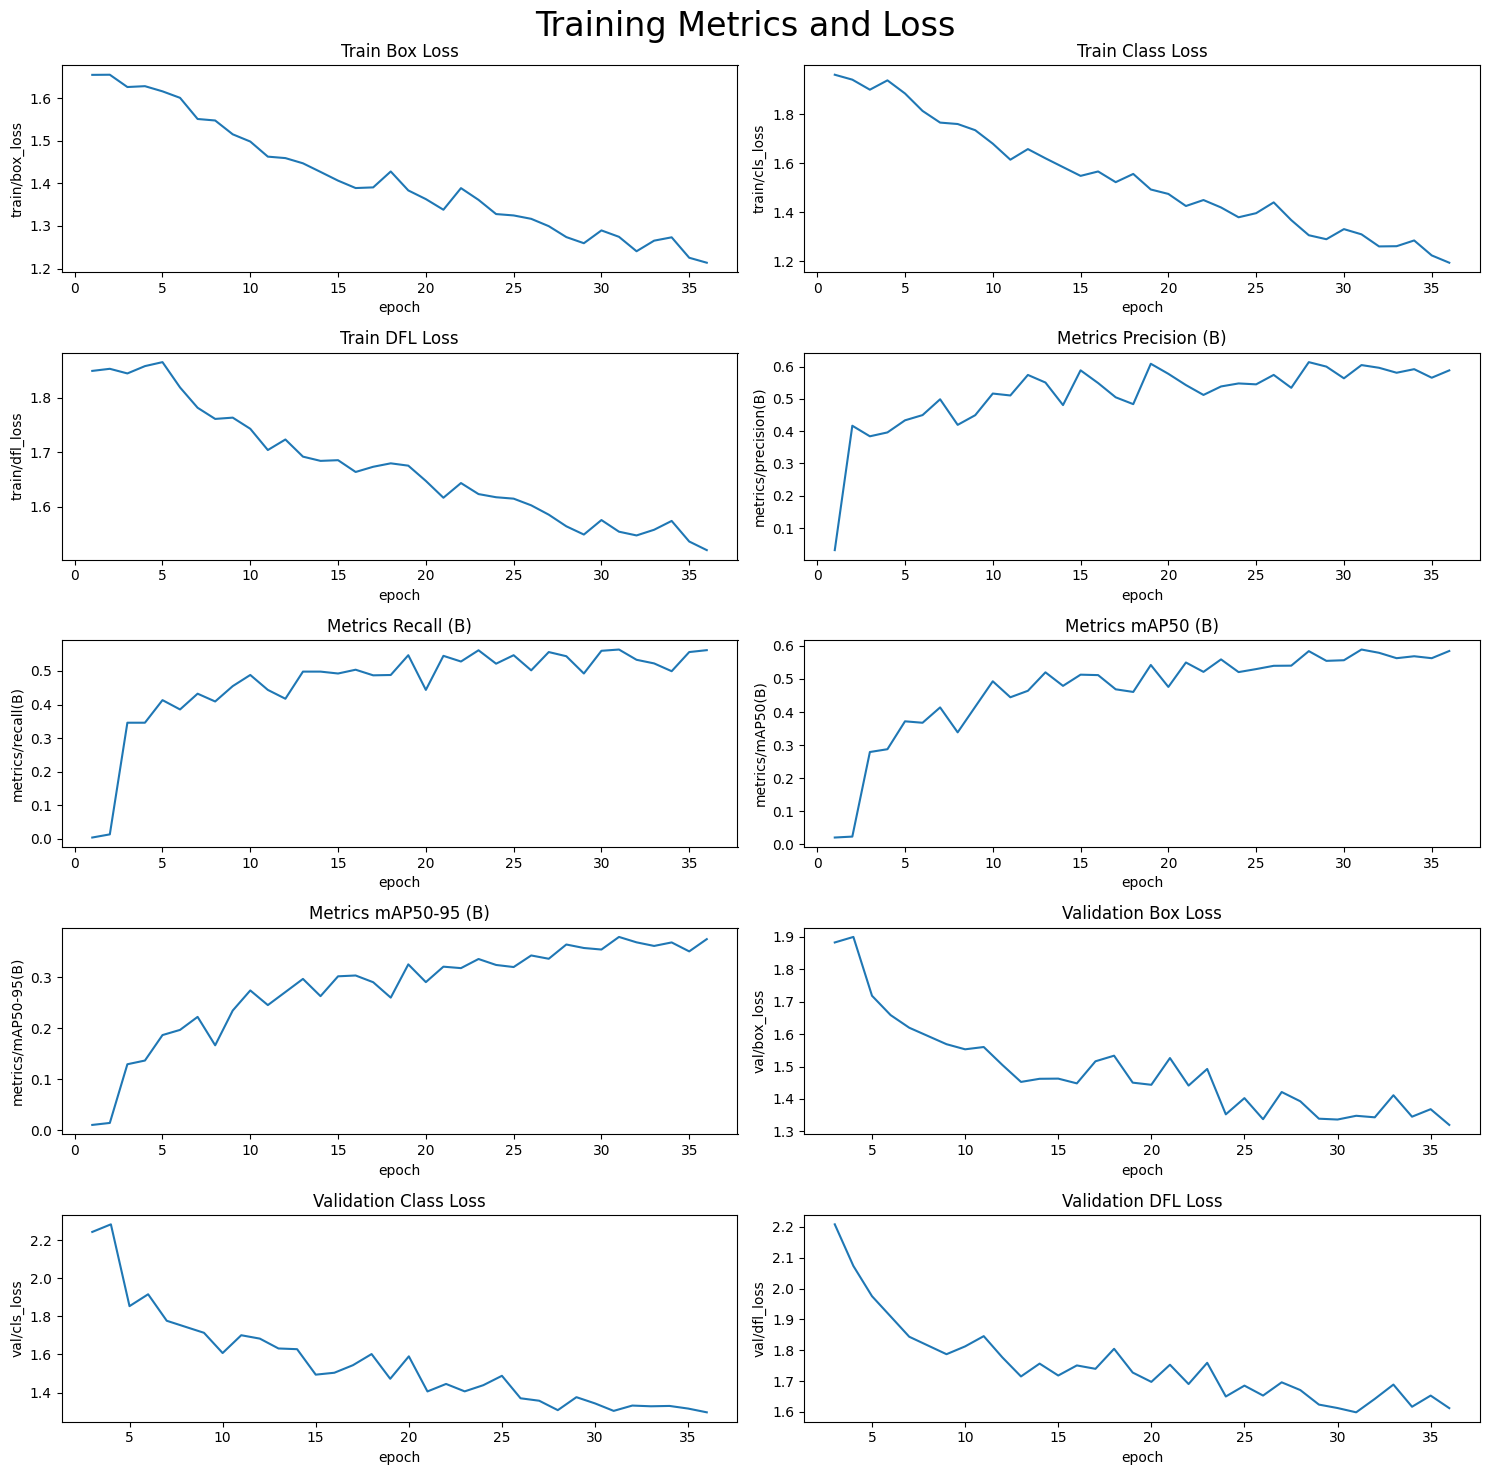

In [16]:
# -------------------- Plot metrics --------------------

show_csv_results("./runs/detect/train/results.csv")

In [17]:
# -------------------- Evaluate on test dataset --------------------

model = YOLO('./runs/detect/train/weights/best.pt')

metrics = model.val(conf=0.25, split='test')

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 11.2±3.6 MB/s, size: 30.5 KB)


val: Scanning /content/dataset/leaf_dataset/yolo_matched/test/labels... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<00:00, 897.82it/s]

val: New cache created: /content/dataset/leaf_dataset/yolo_matched/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


                   all        113        626      0.636       0.57      0.628      0.451
Speed: 2.0ms preprocess, 67.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


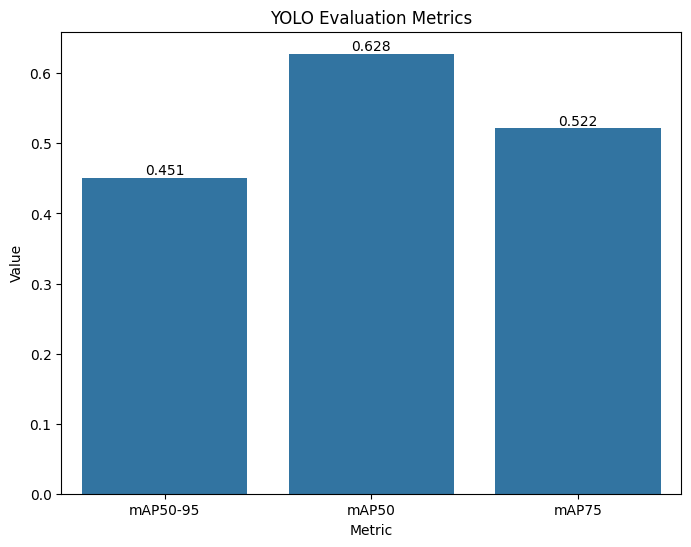

In [18]:
# -------------------- Show evaluation metrics --------------------

show_metrics(metrics)

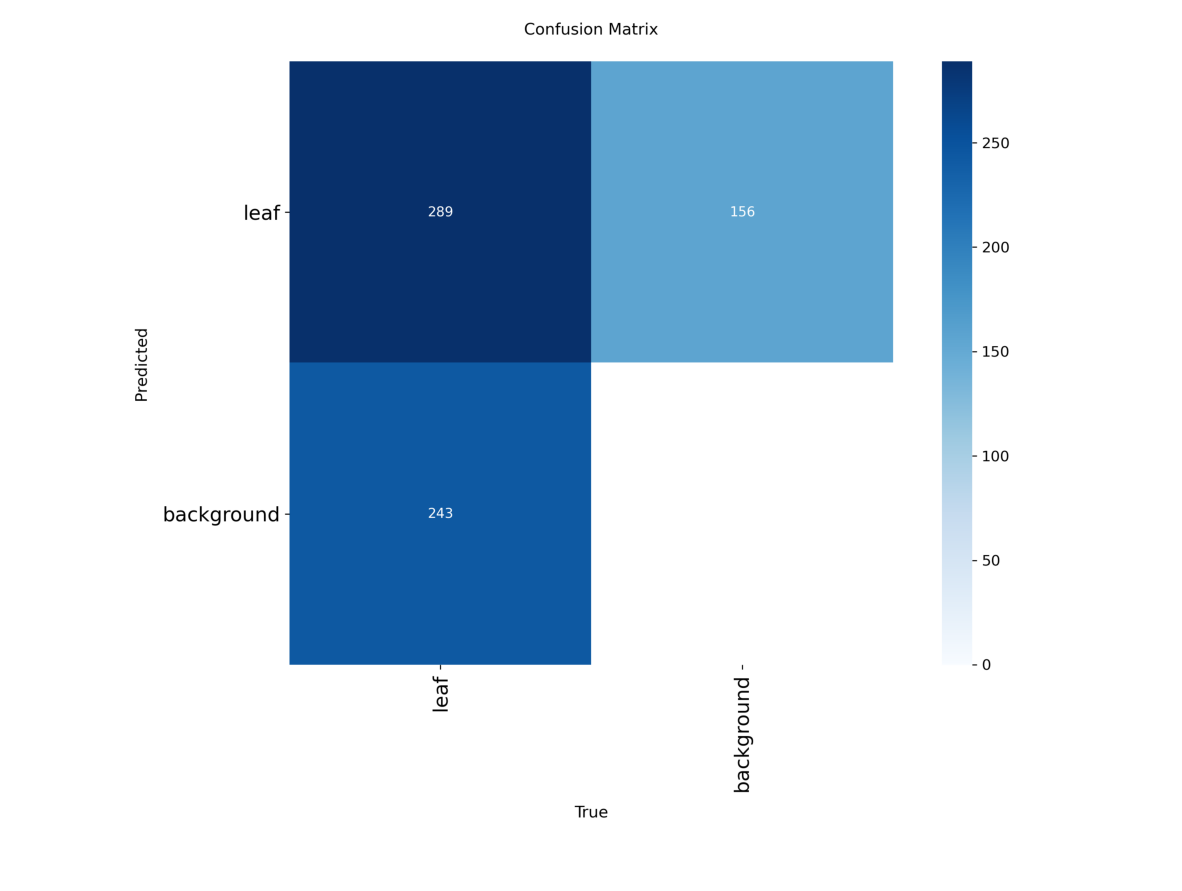

In [19]:
# -------------------- Confusion matrix --------------------

matrix_path = './runs/detect/train/confusion_matrix.png'
show_image(matrix_path)


0: 640x640 2 leafs, 93.0ms
Speed: 3.5ms preprocess, 93.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 58.7ms
Speed: 4.3ms preprocess, 58.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 58.9ms
Speed: 3.6ms preprocess, 58.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 58.0ms
Speed: 3.6ms preprocess, 58.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 58.3ms
Speed: 3.2ms preprocess, 58.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 55.6ms
Speed: 3.7ms preprocess, 55.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 57.6ms
Speed: 4.0ms preprocess, 57.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 leafs, 56.2ms
Speed: 3.5ms preprocess, 56.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640

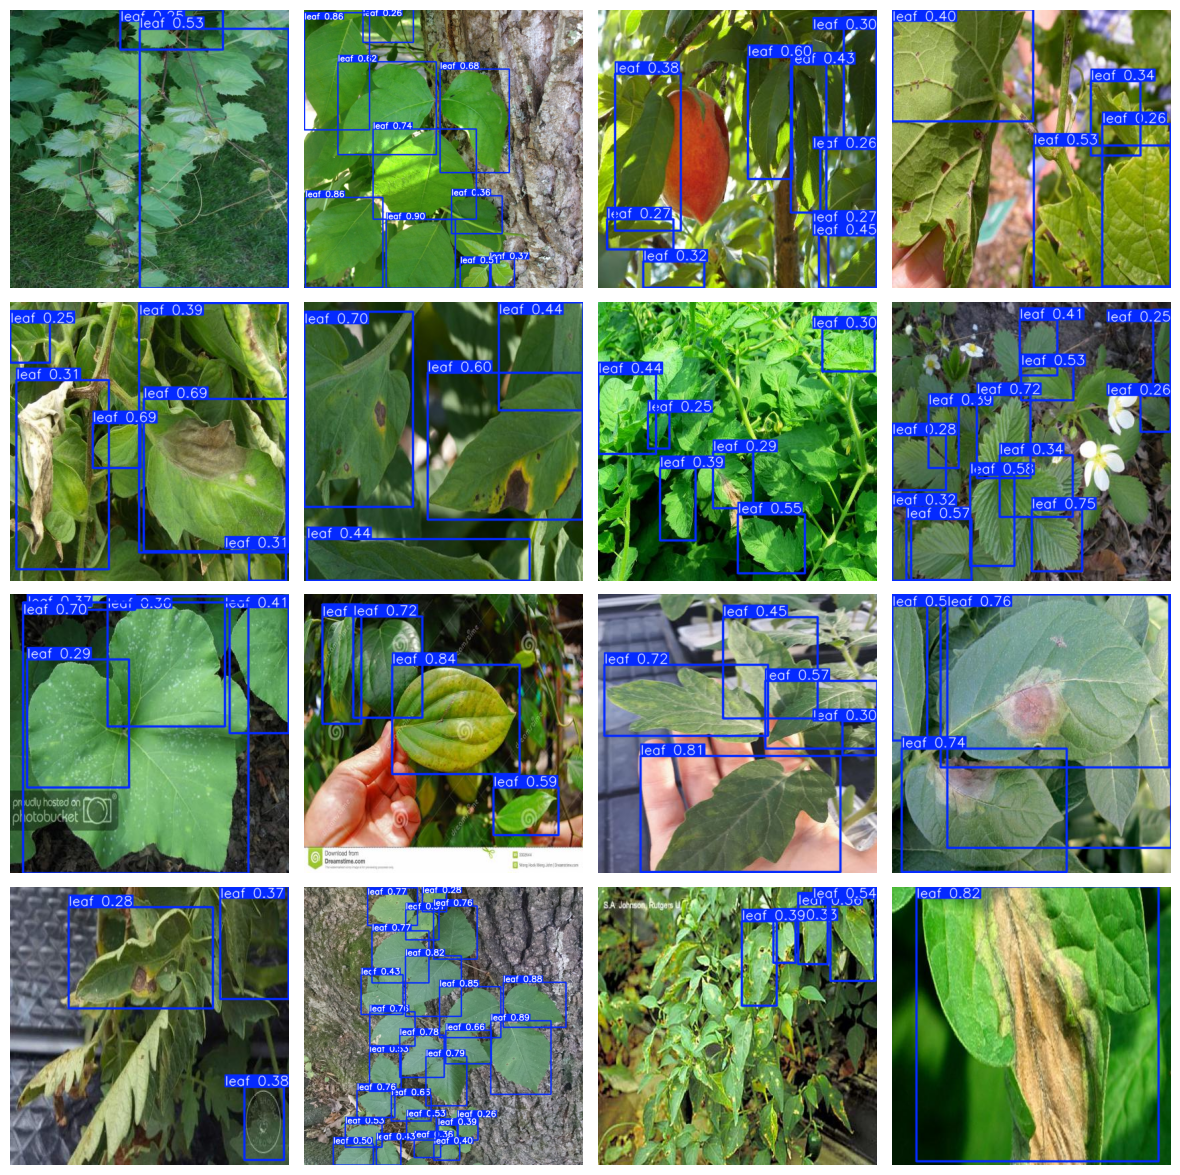

In [20]:
# -------------------- Show test detections --------------------

show_detections(test_images, num_images=16, rows=4, columns=4)